In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random

def dag(X):
    return X.conj().T

# This function reduces arrays which are only composed by one element to scalars.
def sq(x):
    return np.squeeze(x)

# This function gives the σ matrices.
def σ(i,j):
    v_i = np.zeros((3,1), dtype="complex128")
    v_i[i-1][0] = 1
    v_j = np.zeros((3,1), dtype="complex128")
    v_j[j-1][0] = 1    
    return v_i @ dag(v_j) 

number_operator = np.array(np.diag([1,2,3]), dtype="complex128")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Parameters.
θH = 0 # Parameter (must be zero to have a linear GKSL evolution)
θC = 0 # Parameter (must be zero to have a linear GKSL evolution)
γH = 1 # Bath coupling strength
γC= 1 # Bath coupling strength
βH= 0.8 # Inverse temperature of the thermal bath
βC= 1 # Inverse temperature of the thermal bath
# TODO: better define the following two parameters
Δ = 1 # Detuning parameter
Ω = 1 # "Rabi" frequency
dt = 0.001
t_max = 10

# Bose-Einstein Nbar calculations to be done in detail, for now I fix directly the average occupation nbar.
# NbarH = 1. / (np.exp(-βR * ωR) - 1.)
# NbarC = 1. / (np.exp(-βL * ωL) - 1.)
NbarH = 5
NbarC = 2

t_range = np.arange(0, t_max, dt)

# And the identity matrix.
ide = np.array([[1,0,0],[0,1,0],[0,0,1]], dtype="complex128")
# And the zero matrix
zero = np.array([[0,0,0],[0,0,0],[0,0,0]], dtype="complex128")

L_Hin = np.sqrt(γH * NbarH) * σ(3,1)
L_Hout = np.sqrt(γH * (NbarH + 1)) * σ(1,3)
L_Cout = np.sqrt(γC * NbarC) * σ(3,2)
L_Cin = np.sqrt(γC * (NbarC + 1)) * σ(2,3)

H = - Δ * σ(2,2) + Ω * (σ(1,2) + σ(2,1))

In [3]:
def execute_step(ψ0, ϕH0, ϕC0, SH0, SC0, print_jumps=False):
    # Note that this uses the SSE (not the SME) version of the stochastic evolution of the monitoring vector (see Albarelli et al. 2018).
    ρ = ψ0 @ dag(ψ0)
    
    # Computes the value of H in the perturbative dynamics.
    Hθ = (1 + θH + θC) * H
    
    # Computes the value of the jump operators coefficients in the perturbative dynamics.
    l_Hin = (np.trace(L_Hin @ ρ @ dag(L_Hin)) - np.trace(L_Hout @ ρ @ dag(L_Hout))) / (np.trace(L_Hin @ ρ @ dag(L_Hin)) + np.trace(L_Hout @ ρ @ dag(L_Hout)))
    l_Hout = - l_Hin
    l_Cin = (np.trace(L_Cin @ ρ @ dag(L_Cin)) - np.trace(L_Cout @ ρ @ dag(L_Cout))) / (np.trace(L_Cin @ ρ @ dag(L_Cin)) + np.trace(L_Cout @ ρ @ dag(L_Cout)))
    l_Cout = - l_Cin
    
    # If some of the values is NaN, brings to 0 (is this correct?).
    if np.isnan(l_Hin):
        l_Hin = 0
    if np.isnan(l_Hout):
        l_Hout = 0
    if np.isnan(l_Cin):
        l_Cin = 0
    if np.isnan(l_Cout):
        l_Cout = 0
    
    # Computes the jump operators.
    Lθ_Hin = np.sqrt(1 + l_Hin * θH) * L_Hin
    Lθ_Hout = np.sqrt(1 + l_Hout * θH) * L_Hout
    Lθ_Cin = np.sqrt(1 + l_Cin * θC) * L_Cin
    Lθ_Cout = np.sqrt(1 + l_Cout * θC) * L_Cout
    
    # Overall jump operator.
    J = dag(Lθ_Hin) @ Lθ_Hin + dag(Lθ_Hout) @ Lθ_Hout + dag(Lθ_Cin) @ Lθ_Cin + dag(Lθ_Cout) @ Lθ_Cout
    
    # Effective Hamiltonian.
    Heff = Hθ - 1j/2. * J
    
    # Kraus operators for infinitesimal time evolution.
    V_0 = ide - 1j * Heff * dt
    V_Hin = Lθ_Hin * np.sqrt(dt)
    V_Hout = Lθ_Hout * np.sqrt(dt)
    V_Cin = Lθ_Cin * np.sqrt(dt)
    V_Cout = Lθ_Cout * np.sqrt(dt)
    
    # Derivatives of the Kraus operators for the FI evolution with respect to θH.
    dV_0_H = - 1j * (H - 1j/2. * (l_Hin * dag(L_Hin) @ L_Hin + l_Hout * dag(L_Hout) @ L_Hout)) * dt
    dV_Hin_H = l_Hin / (2 * np.sqrt(1 + l_Hin * θH)) * L_Hin * np.sqrt(dt)
    dV_Hout_H = l_Hout / (2 * np.sqrt(1 + l_Hout * θH)) * L_Hout * np.sqrt(dt)
    dV_Cin_H = zero
    dV_Cout_H = zero
    
    # Derivatives of the Kraus operators for the FI evolution with respect to θC.
    dV_0_C = - 1j * (H - 1j/2. * (l_Cin * dag(L_Cin) @ L_Cin + l_Cout * dag(L_Cout) @ L_Cout)) * dt
    dV_Hin_C = zero
    dV_Hout_C = zero
    dV_Cin_C = l_Cin / (2 * np.sqrt(1 + l_Cin * θC)) * L_Cin * np.sqrt(dt)
    dV_Cout_C = l_Cout / (2 * np.sqrt(1 + l_Cout * θC)) * L_Cout * np.sqrt(dt)
    
    
    # Corresponding probabilities.
    p_Hin = np.real(dag(ψ0) @ dag(V_Hin) @ V_Hin @ ψ0)[0][0]
    p_Hout = np.real(dag(ψ0) @ dag(V_Hout) @ V_Hout @ ψ0)[0][0]
    p_Cin = np.real(dag(ψ0) @ dag(V_Cin) @ V_Cin @ ψ0)[0][0]
    p_Cout = np.real(dag(ψ0) @ dag(V_Cout) @ V_Cout @ ψ0)[0][0]
    
    # p_0 is defined in order to guarantee normalisation.
    p_0 = 1 - (p_Hin + p_Hout + p_Cin + p_Cout)
    
    # Chooses the Kraus operator to apply.
    t_V = np.random.choice(["V_0", "V_Hin", "V_Hout", "V_Cin", "V_Cout"], p=[p_0, p_Hin, p_Hout, p_Cin, p_Cout])
    
    # Lookup tables for conversion to proper operator, and to its derivative.
    dict_V = {"V_0": V_0, "V_Hin": V_Hin, "V_Hout": V_Hout, "V_Cin": V_Cin, "V_Cout": V_Cout}
    dict_dV_H = {"V_0": dV_0_H, "V_Hin": dV_Hin_H, "V_Hout": dV_Hout_H, "V_Cin": dV_Cin_H, "V_Cout": dV_Cout_H}
    dict_dV_C = {"V_0": dV_0_C, "V_Hin": dV_Hin_C, "V_Hout": dV_Hout_C, "V_Cin": dV_Cin_C, "V_Cout": dV_Cout_C}
    
    V = dict_V[t_V]
    dV_H = dict_dV_H[t_V]
    dV_C = dict_dV_C[t_V]
    
    # If a jump has happened, updates the accumulator of irreversible entropy produced so far.
    if t_V == "V_Hin":
        SH = SH0 + np.real(l_Hin)**2
        SC = SC0
    elif t_V == "V_Hout":
        SH = SH0 + np.real(l_Hout)**2
        SC = SC0
    elif t_V == "V_Cin":
        SH = SH0
        SC = SC0 + np.real(l_Cin)**2
    elif t_V == "V_Cout":
        SH = SH0
        SC = SC0 + np.real(l_Cout)**2
    else:
        SH = SH0 # No entropy production for coherent evolution only.
        SC = SC0
        
    if print_jumps and (t_V != "V_0"):
        print(f"Jump happened in channel {t_V}")
        
    
    # Updates the state.
    ψ = V @ ψ0 / np.linalg.norm(V @ ψ0)
    
    # Updates the two monitoring operators.
    ϕH = (dV_H @ ψ0 + V @ ϕH0) / np.linalg.norm(V @ ψ0)
    ϕC = (dV_C @ ψ0 + V @ ϕC0) / np.linalg.norm(V @ ψ0)
    
    return ψ, ϕH, ϕC, SH, SC

In [4]:
v_exp_number = []
v_stoch_entropy_C = []
v_stoch_entropy_H = []
v_stoch_fHH = []
v_stoch_fCC = []
v_stoch_fHC = []

# Initial settings.
ψ0 = np.array([[1],[0],[0]], dtype="complex128")
ϕC0 = np.array([[0],[0],[0]], dtype="complex128")
ϕH0 = np.array([[0],[0],[0]], dtype="complex128")
SC0 = 0
SH0 = 0

ψ = ψ0
ϕC = ϕC0
ϕH = ϕH0
SC = SC0
SH = SH0
for t in t_range:
    ψ, ϕH, ϕC, SH, SC = execute_step(ψ, ϕH, ϕC, SH, SC, True)
    exp_number = np.real(dag(ψ) @ number_operator @ ψ)[0][0]
    stoch_entropy_C = SC
    stoch_entropy_H = SH
    stoch_fHH = sq(np.real(dag(ψ) @ ϕH + dag(ϕH) @ ψ))**2
    stoch_fCC = sq(np.real(dag(ψ) @ ϕC + dag(ϕC) @ ψ))**2
    stoch_fHC = sq(np.real(dag(ψ) @ ϕC + dag(ϕC) @ ψ)) * sq(np.real(dag(ψ) @ ϕH + dag(ϕH) @ ψ))
    
    v_exp_number.append(exp_number)
    v_stoch_entropy_C.append(stoch_entropy_C)
    v_stoch_entropy_H.append(stoch_entropy_H)
    v_stoch_fHH.append(stoch_fHH)
    v_stoch_fCC.append(stoch_fCC)
    v_stoch_fHC.append(stoch_fHC)

/var/folders/mj/qz886q915k5ggfbpry894rl40000gn/T/ipykernel_47350/1277154138.py:11: RuntimeWarning: invalid value encountered in scalar divide
  l_Cin = (np.trace(L_Cin @ ρ @ dag(L_Cin)) - np.trace(L_Cout @ ρ @ dag(L_Cout))) / (np.trace(L_Cin @ ρ @ dag(L_Cin)) + np.trace(L_Cout @ ρ @ dag(L_Cout)))
/var/folders/mj/qz886q915k5ggfbpry894rl40000gn/T/ipykernel_47350/1277154138.py:9: RuntimeWarning: invalid value encountered in scalar divide
  l_Hin = (np.trace(L_Hin @ ρ @ dag(L_Hin)) - np.trace(L_Hout @ ρ @ dag(L_Hout))) / (np.trace(L_Hin @ ρ @ dag(L_Hin)) + np.trace(L_Hout @ ρ @ dag(L_Hout)))


Jump happened in channel V_Cout
Jump happened in channel V_Cin
Jump happened in channel V_Cout
Jump happened in channel V_Hout
Jump happened in channel V_Hin
Jump happened in channel V_Hout
Jump happened in channel V_Hin
Jump happened in channel V_Cin
Jump happened in channel V_Cout
Jump happened in channel V_Hout
Jump happened in channel V_Hin
Jump happened in channel V_Hout
Jump happened in channel V_Hin
Jump happened in channel V_Cin
Jump happened in channel V_Cout
Jump happened in channel V_Cin
Jump happened in channel V_Cout
Jump happened in channel V_Cin
Jump happened in channel V_Cout
Jump happened in channel V_Hout
Jump happened in channel V_Hin
Jump happened in channel V_Hout
Jump happened in channel V_Hin
Jump happened in channel V_Hout
Jump happened in channel V_Hin
Jump happened in channel V_Hout
Jump happened in channel V_Hin
Jump happened in channel V_Hout
Jump happened in channel V_Hin
Jump happened in channel V_Cin
Jump happened in channel V_Cout
Jump happened in channe

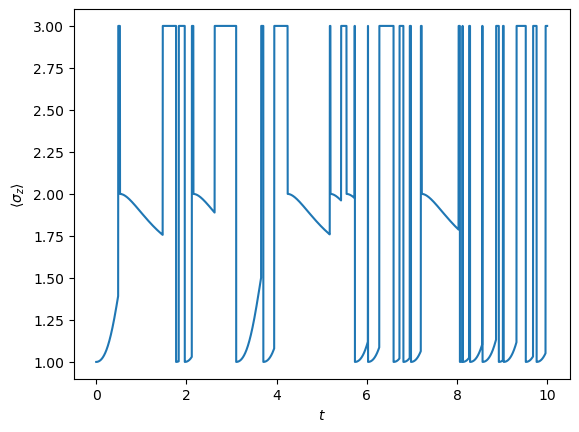

In [5]:
plt.plot(t_range, v_exp_number)
plt.xlabel("$t$")
plt.ylabel("$\\langle\\sigma_z\\rangle$")
plt.show()

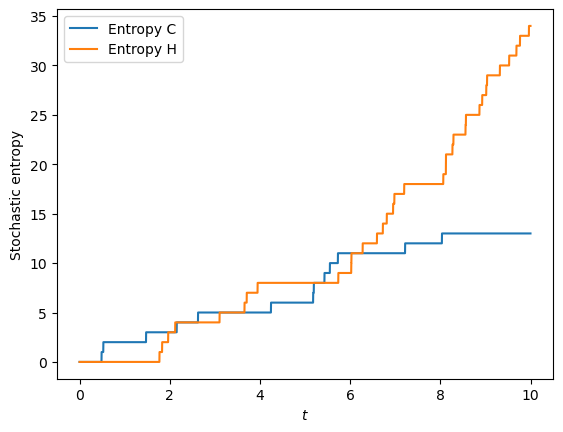

In [6]:
plt.plot(t_range, v_stoch_entropy_C, label="Entropy C")
plt.plot(t_range, v_stoch_entropy_H, label="Entropy H")
plt.xlabel("$t$")
plt.ylabel("Stochastic entropy")
plt.legend()
plt.show()

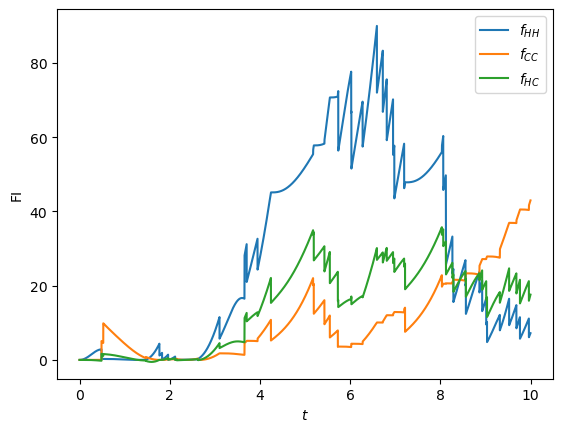

In [7]:
plt.plot(t_range, v_stoch_fHH, label="$f_{HH}$")
plt.plot(t_range, v_stoch_fCC, label="$f_{CC}$")
plt.plot(t_range, v_stoch_fHC, label="$f_{HC}$")
plt.xlabel("$t$")
plt.ylabel("FI")
plt.legend()
plt.show()

In [8]:
number_trajectories = 200

v_ave_exp_number = np.zeros(len(t_range))
v_ave_entropy_H = np.zeros(len(t_range))
v_ave_entropy_C = np.zeros(len(t_range))
v_ave_fHH = np.zeros(len(t_range))
v_ave_fCC = np.zeros(len(t_range))
v_ave_fHC = np.zeros(len(t_range))

# Initial settings.
ψ0 = np.array([[1],[0],[0]], dtype="complex128")
ϕC0 = np.array([[0],[0],[0]], dtype="complex128")
ϕH0 = np.array([[0],[0],[0]], dtype="complex128")
SC0 = 0
SH0 = 0

for trajectory in range(number_trajectories):
    ψ = ψ0
    ϕC = ϕC0
    ϕH = ϕH0
    SC = SC0
    SH = SH0
    for n_t, t in enumerate(t_range):
        ψ, ϕH, ϕC, SH, SC = execute_step(ψ, ϕH, ϕC, SH, SC)
        exp_number = np.real(dag(ψ) @ number_operator @ ψ)[0][0]
        stoch_entropy_C = SC
        stoch_entropy_H = SH
        stoch_fHH = sq(np.real(dag(ψ) @ ϕH + dag(ϕH) @ ψ))**2
        stoch_fCC = sq(np.real(dag(ψ) @ ϕC + dag(ϕC) @ ψ))**2
        stoch_fHC = sq(np.real(dag(ψ) @ ϕC + dag(ϕC) @ ψ)) * sq(np.real(dag(ψ) @ ϕH + dag(ϕH) @ ψ))

        v_ave_exp_number[n_t] += exp_number / number_trajectories 
        v_ave_entropy_C[n_t] += stoch_entropy_C / number_trajectories
        v_ave_entropy_H[n_t] += stoch_entropy_H / number_trajectories
        v_ave_fHH[n_t] += stoch_fHH / number_trajectories
        v_ave_fCC[n_t] += stoch_fCC / number_trajectories
        v_ave_fHC[n_t] += stoch_fHC / number_trajectories
        
    print(f"Completed for trajectory {trajectory}")

/var/folders/mj/qz886q915k5ggfbpry894rl40000gn/T/ipykernel_47350/1277154138.py:11: RuntimeWarning: invalid value encountered in scalar divide
  l_Cin = (np.trace(L_Cin @ ρ @ dag(L_Cin)) - np.trace(L_Cout @ ρ @ dag(L_Cout))) / (np.trace(L_Cin @ ρ @ dag(L_Cin)) + np.trace(L_Cout @ ρ @ dag(L_Cout)))
/var/folders/mj/qz886q915k5ggfbpry894rl40000gn/T/ipykernel_47350/1277154138.py:9: RuntimeWarning: invalid value encountered in scalar divide
  l_Hin = (np.trace(L_Hin @ ρ @ dag(L_Hin)) - np.trace(L_Hout @ ρ @ dag(L_Hout))) / (np.trace(L_Hin @ ρ @ dag(L_Hin)) + np.trace(L_Hout @ ρ @ dag(L_Hout)))


Completed for trajectory 0
Completed for trajectory 1
Completed for trajectory 2
Completed for trajectory 3
Completed for trajectory 4
Completed for trajectory 5
Completed for trajectory 6
Completed for trajectory 7
Completed for trajectory 8
Completed for trajectory 9
Completed for trajectory 10
Completed for trajectory 11
Completed for trajectory 12
Completed for trajectory 13
Completed for trajectory 14
Completed for trajectory 15
Completed for trajectory 16
Completed for trajectory 17
Completed for trajectory 18
Completed for trajectory 19
Completed for trajectory 20
Completed for trajectory 21
Completed for trajectory 22
Completed for trajectory 23
Completed for trajectory 24
Completed for trajectory 25
Completed for trajectory 26
Completed for trajectory 27
Completed for trajectory 28
Completed for trajectory 29
Completed for trajectory 30
Completed for trajectory 31
Completed for trajectory 32
Completed for trajectory 33
Completed for trajectory 34
Completed for trajectory 35
Co

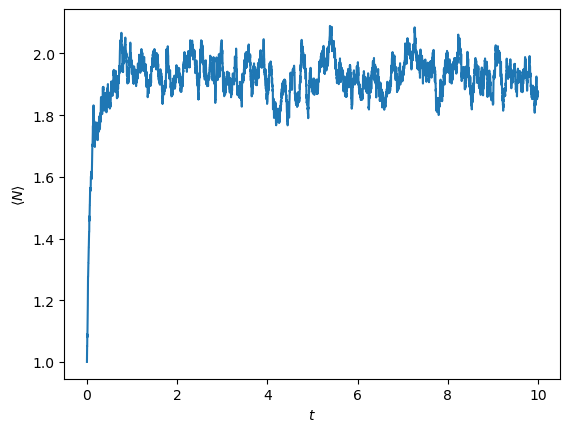

In [9]:
plt.plot(t_range, v_ave_exp_number)
plt.xlabel("$t$")
plt.ylabel("$\\langle N \\rangle$")
plt.show()

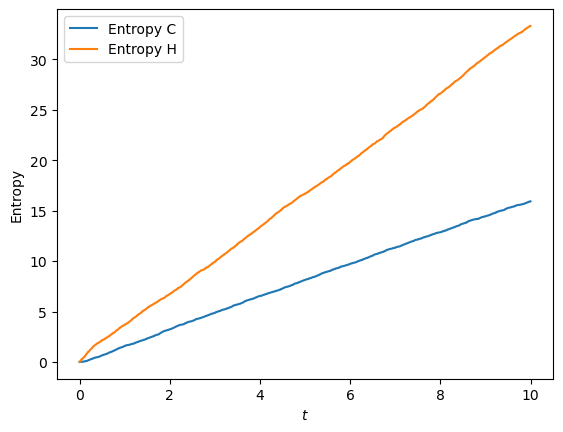

In [10]:
plt.plot(t_range, v_ave_entropy_C, label="Entropy C")
plt.plot(t_range, v_ave_entropy_H, label="Entropy H")
plt.xlabel("$t$")
plt.ylabel("Entropy")
plt.legend()
plt.show()

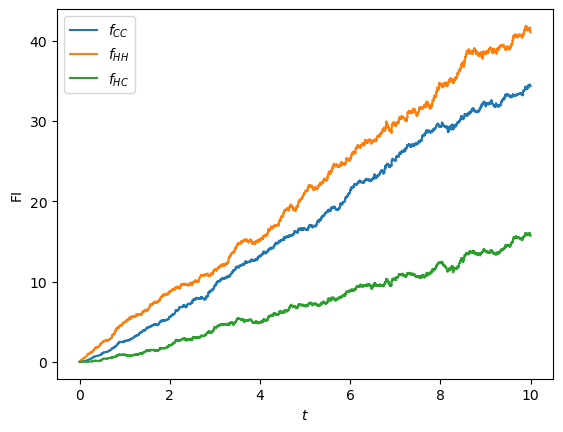

In [11]:
plt.plot(t_range, v_ave_fCC, label="$f_{CC}$")
plt.plot(t_range, v_ave_fHH, label="$f_{HH}$")
plt.plot(t_range, v_ave_fHC, label="$f_{HC}$")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("FI")
plt.show()

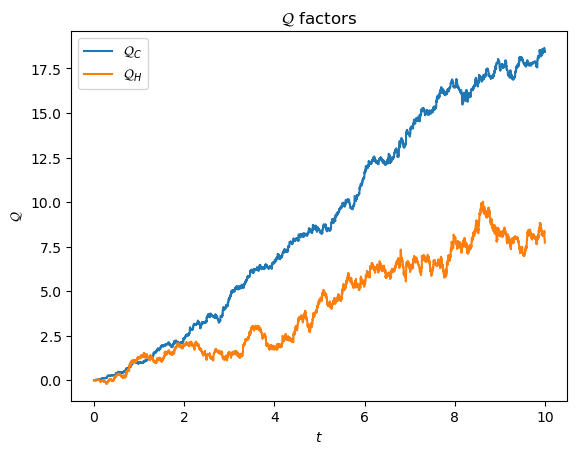

In [12]:
v_QC = v_ave_fCC - v_ave_entropy_C
v_QH = v_ave_fHH - v_ave_entropy_H

plt.plot(t_range, v_QC, label="$\mathcal{Q}_C$")
plt.plot(t_range, v_QH, label="$\mathcal{Q}_H$")
plt.xlabel("$t$")
plt.ylabel("$\mathcal{Q}$")
plt.title("$\mathcal{Q}$ factors")
plt.legend()
plt.show()

In [13]:
file_out = open("QuantumData_ThreeLevelsMaser.dat", "w")
file_out.write("# t \t IC \t IH \t IHC \n")
for n_t, t in enumerate(t_range):
    file_out.write(f"{t}\t{v_ave_fCC[n_t]}\t{v_ave_fHH[n_t]}\t{v_ave_fHC[n_t]}\n")
file_out.close()